# Import Libraries

In [26]:
import os
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import matplotlib.pyplot as plt
import random
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
#from efficientnet_pytorch import model as enet

import cv2
import timm

from tqdm import tqdm
from tqdm.notebook import tqdm

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, CenterCrop, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, RandomRotate90, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

import logging
import time
from contextlib import contextmanager

# Config

In [27]:
class CFG:
    DATA_PATH = '../input/plant-pathology-2021-fgvc8/'
    TEST_PATH = DATA_PATH + 'test_images/'
    TRAIN_PATH = DATA_PATH + 'train_images/'
    TRAIN_CSV_PATH = DATA_PATH + 'train.csv'
    TEST_CSV_PATH = DATA_PATH + 'sample_submission.csv'
    
    #MODEL_ARCH ='resnet101'
    MODEL_ARCH = 'vgg11'
    IMG_SIZE = 224
    EPOCH = 10
    BATCH_SIZE = 32
    DEBUG_SIZE = 0.1
    RANDOM_STATE = 1234
    CLASS_THRESHOLD = 0.4
    DROPOUT = .4
    LR = 5e-4
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #LABELS = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
    
    N_CLASS = 12
    LABELS_DICT = {
    0: 'complex', 
    1: 'frog_eye_leaf_spot',
    2: 'frog_eye_leaf_spot complex',
    3: 'frog_eye_leaf_spot',
    4: 'healthy', 
    5: 'powdery_mildew complex',
    6: 'rust',
    7: 'rust complex',
    8: 'rust frog_eye_leaf_spot',
    9: 'scab',
    10: 'scab frog_eye_leaf_spot',
    11: 'scab frog_eye_leaf_spot complex'
    }

# Load DataFrame

In [28]:
train_df = pd.read_csv(CFG.TRAIN_CSV_PATH)
sub_df = pd.read_csv(CFG.TEST_CSV_PATH)

# EDA

In [29]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [30]:
sub_df

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [31]:
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

# Visualize Image

In [32]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for x, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, x + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

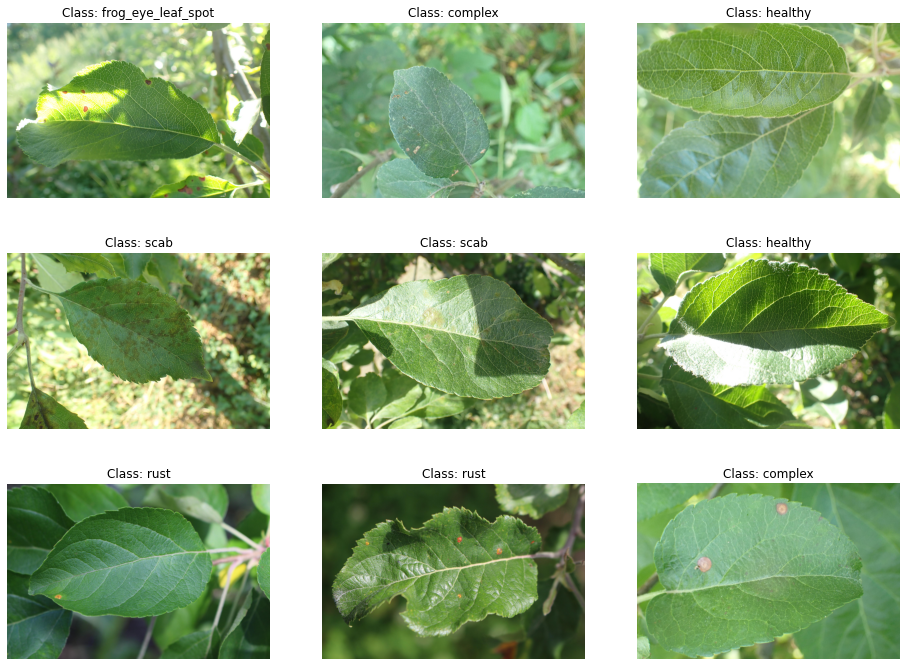

In [33]:
tmp_df = train_df.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(CFG.TRAIN_PATH,image_ids,labels)

# Encode To Unique Label

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(train_df.labels)
train_df['labels'] = le.transform(train_df.labels)

In [35]:
train_df

,image,labels
0,800113bb65efe69e.jpg,3
1,8002cb321f8bfcdf.jpg,11
2,80070f7fb5e2ccaa.jpg,9
3,80077517781fb94f.jpg,9
4,800cbf0ff87721f8.jpg,0
...,...,...
18627,fffb900a92289a33.jpg,3
18628,fffc488fa4c0e80c.jpg,9
18629,fffc94e092a59086.jpg,6
18630,fffe105cf6808292.jpg,10


In [36]:
CFG.LABELS_DICT

{0: 'complex',
 1: 'frog_eye_leaf_spot',
 2: 'frog_eye_leaf_spot complex',
 3: 'frog_eye_leaf_spot',
 4: 'healthy',
 5: 'powdery_mildew complex',
 6: 'rust',
 7: 'rust complex',
 8: 'rust frog_eye_leaf_spot',
 9: 'scab',
 10: 'scab frog_eye_leaf_spot',
 11: 'scab frog_eye_leaf_spot complex'}

# Seed

In [37]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

@contextmanager
def timer(name, logger=None, level=logging.DEBUG):
    print_ = print if logger is None else lambda msg: logger.log(level, msg)
    t0 = time.time()
    print_(f'[{name}] start')
    yield
    print_(f'[{name}] done in {time.time() - t0:.0f} s')

In [38]:
def to_numpy(tensor):
    """Auxiliary function to convert tensors into numpy arrays
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


# Debug

In [39]:
DEBUG = False
if DEBUG:
    train_df = train_df.sample(frac = 0.05).reset_index(drop = True)
    print(train_df.shape)

# Split data

In [40]:
from sklearn.model_selection import train_test_split
train, valid =  train_test_split(train_df, test_size = 0.2)
print(train.shape, valid.shape)

(14905, 2) (3727, 2)


# Dataset

All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite __getitem__(), supporting fetching a data sample for a given key. Subclasses could also optionally overwrite __len__(), which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader.

In [41]:
#pytorchのDatasetクラスを継承したクラスを作成する
class TrainDataset(Dataset):
    def __init__(self, df, transform = None): #初期化
        self.df = df
        self.image_names = df["image"].values
        self.labels = df["labels"].values
        self.transform = transform
        
#データの長さを返す関数
    def __len__(self):
        return len(self.df)
    
#indexに対応する画像とラベルを返す関数
    def __getitem__(self, idx):
        image_name = self.image_names[idx] #indexに対応するimageの値
        image_path = CFG.TRAIN_PATH + image_name #indexに対応するデータのパス
        image = cv2.imread(image_path) #画像読み込み
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR→RGB
        label = self.labels[idx] #indexに対応するラベル
        #label = torch.tensor(self.labels[idx]).float()
        if self.transform: #前処理ある場合
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# Transform

In [42]:
def get_transforms(data):
    
    if data == 'train':
        return Compose([
            A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            #A.RandomResizedCrop(CFG.IMG_SIZE, CFG.IMG_SIZE),
            #A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5),
            #A.RandomBrightnessContrast(p=0.5),

            A.Normalize(),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            Normalize(),
            ToTensorV2(),
        ])

In [43]:
# 上で作成したデータセットクラスを呼び出す
train_dataset = TrainDataset(train, transform = get_transforms(data = 'train'))
# データセットクラスによって取り出されるデータをbatch数でまとめる
train_loader = DataLoader(train_dataset, CFG.BATCH_SIZE, shuffle = True,drop_last = True, num_workers=2)

In [44]:
valid_dataset = TrainDataset(valid, transform = get_transforms(data = 'valid'))
valid_loader = DataLoader(valid_dataset, CFG.BATCH_SIZE, shuffle = False, num_workers=2)

# Create model

In [45]:
class VGG(nn.Module):
    """
        Base class for all neural network modules.
        Your models should also subclass this class.
        Modules can also contain other Modules, allowing to nest them in a tree structure.
        You can assign the submodules as regular attributes:
    """
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = timm.create_model(model_name = CFG.MODEL_ARCH,pretrained = False)
        in_features = self.vgg.head.fc.in_features
        self.vgg.head.fc = nn.Linear(in_features, CFG.N_CLASS)#(input_size,output_size)
        
    def forward(self, x):
        x = self.vgg(x)
        return x
    
model = VGG()

In [46]:
model

VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_size=2, str

# Training

In [47]:
plot_train_loss = []
plot_train_acc = []
plot_train_f1 = []

plot_valid_loss = []
plot_valid_acc = []
plot_valid_f1 = []

In [48]:
def train_model(datasets, dataloaders, model, criterion, optimizer, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_acc = 0.0
            running_f1 = 0.0
            
            stream = tqdm(dataloaders[phase])
            for batch ,(inputs, labels) in enumerate(stream, start=1):
                inputs = inputs.to(CFG.DEVICE)
                labels = labels.to(CFG.DEVICE)
               
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(CFG.DEVICE)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                #print(loss, loss.item())
                # Statistics input_size(0)=32 .item()はキーとバリューを取得
                running_loss += loss.item()
                running_acc += accuracy_score(to_numpy(preds), to_numpy(labels), normalize=True)
                #running_corrects += torch.sum(preds == labels.data)
                running_f1 += f1_score(to_numpy(preds), to_numpy(labels), average='macro')
                #print(inputs.size(0), running_loss)
            
            #if phase == 'train':
                #scheduler.step()
                
            epoch_loss = running_loss / batch
            epoch_acc = running_acc / batch
            epoch_f1 = running_f1/batch
            
            if phase == 'train':
                plot_train_loss.append(epoch_loss)
                plot_train_acc.append(epoch_acc)
                plot_train_f1.append(epoch_f1)
            else:
                plot_valid_loss.append(epoch_loss)
                plot_valid_acc.append(epoch_acc)
                plot_valid_f1.append(epoch_f1)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))
            
            if phase == 'valid' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:.4f}'.format(best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [49]:
datasets = {'train': train_dataset,
            'valid': valid_dataset}

dataloaders = {'train': train_loader,
               'valid': valid_loader}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 10

In [50]:
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, num_epochs, CFG.DEVICE)

Epoch 1/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.6468 Acc: 0.3825 F1: 0.2517


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.4771 Acc: 0.4621 F1: 0.3166

Epoch 2/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.2194 Acc: 0.5610 F1: 0.4214


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.0067 Acc: 0.6601 F1: 0.4932

Epoch 3/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.9720 Acc: 0.6504 F1: 0.5034


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.8390 Acc: 0.7173 F1: 0.5345

Epoch 4/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.7360 Acc: 0.7638 F1: 0.5800


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.7472 Acc: 0.7605 F1: 0.5783

Epoch 5/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.6203 Acc: 0.8050 F1: 0.6213


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.6043 Acc: 0.8146 F1: 0.6203

Epoch 6/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.5604 Acc: 0.8191 F1: 0.6304


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.6247 Acc: 0.7988 F1: 0.5978

Epoch 7/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.5240 Acc: 0.8290 F1: 0.6427


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.5571 Acc: 0.8258 F1: 0.6303

Epoch 8/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.4806 Acc: 0.8446 F1: 0.6623


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.5643 Acc: 0.8236 F1: 0.6133

Epoch 9/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.4586 Acc: 0.8490 F1: 0.6641


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.5263 Acc: 0.8373 F1: 0.6349

Epoch 10/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 0.4182 Acc: 0.8587 F1: 0.6818


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 0.5132 Acc: 0.8384 F1: 0.6349

Training complete in 358m 9s
Best val F1: 0.6349


In [51]:
model_path = 'new_vgg.pt'
torch.save(model.state_dict(), model_path)

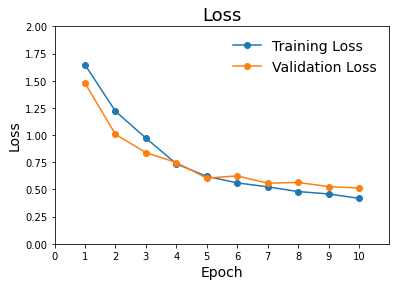

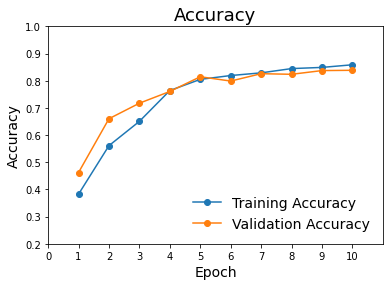

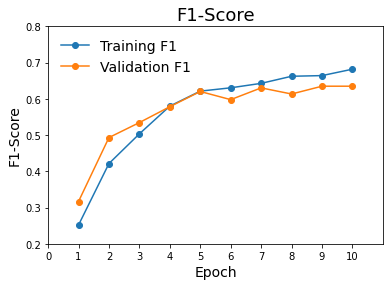

In [53]:
import matplotlib.pyplot as plt

#loss
plt.title("Loss",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss",fontsize=14)

plt.ylim(0, 2.0)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_loss,label='Training Loss',marker ='o')
plt.plot(range(1, 11),plot_valid_loss,label='Validation Loss',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()

#acc
plt.title("Accuracy",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)

plt.ylim(0.2, 1)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_acc,label='Training Accuracy',marker ='o')
plt.plot(range(1, 11),plot_valid_acc,label='Validation Accuracy',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()

#f1
plt.title("F1-Score",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("F1-Score",fontsize=14)

plt.ylim(0.2, 0.8)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_f1,label='Training F1',marker ='o')
plt.plot(range(1, 11),plot_valid_f1,label='Validation F1',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()